#### The goal of this notebook is to study the ligand name location within different articles. You need to make a .pkl file by DataLocation.ipynb

In [1]:
import pandas as pd
import re

articles = pd.read_pickle('processed_articles.pkl')
dataset = pd.read_csv('data/files/20231030_BAN_shared_fixed.csv')

In [2]:
def extract_body(row):
    # Remove the content of specified columns from 'Main Content'
    main_content = row['Main Content']
    abstract = row.get('Abstract', '')
    title = row.get('Title', '')
    conclusion = row.get('Conclusion', '')
    introduction = row.get('Introduction', '')
    
    # Remove the content from 'Main Content'
    body = main_content.replace(abstract, '').replace(title, '').replace(conclusion, '').replace(introduction, '')
    return body.strip()

# Apply the function row-wise to create the 'body' column
articles['Body'] = articles.apply(extract_body, axis=1)
articles.head()

,Filename,Title,DOI,Abstract,Main Content,Introduction,Conclusion,Body
0,10.1021_acssuschemeng.0c05587_0.pdf,Extensive Screening of Green Solvents for Safe...,10.1021/acssuschemeng.0c05587,: Zirconium based metal−organic framework UiO-...,: Zirconium based metal−organic framework UiO-...,After a decade focused on fundamental syntheti...,In this paper an extensive screening of green ...,INTRODUCTIONMOTIVATION AND STRATEGYTaking into...
1,10.1039_c4ce02210f_0.pdf,Interpenetrated and non-interpenetrated homoch...,10.1039/c4ce02210f,A new example of interpenetration that is simp...,Porous metal–organic frameworks (MOFs) have re...,orous metal–organic frameworks (MOFs) have rec...,The present study demonstrates that the interp...,PResults and discussionSynthesis of chiral lig...
2,10.1021_acssuschemeng.6b02115_0.pdf,Dihydrolevoglucosenone (Cyrene) As a Green Alt...,10.1021/acssuschemeng.6b02115,": Cyrene, a green bioderived solvent from wast...",": Cyrene, a green bioderived solvent from wast...","Metal−organic frameworks (MOFs)1,2 are a serie...","In summary, an environmentally friendly dipola...",INTRODUCTIONEXPERIMENTAL SECTIONGeneral Proced...
3,10.1039_b316931f_0.pdf,Helical and network coordination polymers base...,10.1039/b316931f,Cu(I) and Ag(I) coordination polymers of an ax...,Helical and network coordination polymers base...,Section not found,Section not found,Helical and network coordination polymers base...
4,10.1002_chem.202005151_0.pdf,A Showcase of Green Chemistry: Sustainable Syn...,10.1002/chem.202005151,: Zirconium-based metal-organic framework mate...,: Zirconium-based metal-organic framework mate...,Metal-organic frameworks (MOFs) are a kind of ...,ZrMOFs have already proved their value in prac...,"Introduction Green Raw MaterialsMetal sources,..."


In [3]:
dataset = dataset[dataset['reported'] != 'generated']
dataset = dataset.drop_duplicates(subset=['ligand', 'reported'], keep='first')
dataset = dataset[['ligand','reported', 'Category']]
dataset.head()

,ligand,reported,Category
0,"(1R,3S)-1,2,2-trimethyl-3-(pyridin-4-ylcarbamo...",10.1039/c2jm15604k,chiralty
1,"(1R, 3S)-1,2,2-trimethyl-3-(pyridin-3-ylmethyl...",10.1016/j.inoche.2007.01.001,chiralty
2,"1,2,2-trimethyl-3-(pyridin-4-ylcarbamoyl)cyclo...",10.1021/cg101135r,chiralty
4,"(1R,3S)-1,2,2-trimethylcyclopentane-1,3-dicarb...",10.1021/ic502861k,chiralty
5,"benzene-1,4-dicarboxylic acid",10.1016/j.micromeso.2008.06.040,optimization


In [4]:
len(dataset)

135

In [5]:
import pandas as pd
import difflib  # For similarity matching

# Merge dataframes based on DOI
merged_df = pd.merge(dataset, articles, left_on='reported', right_on='DOI', how='left')

# Function to check if ligand name has at least 50% similarity in the text
def find_ligand_location(ligand, text, threshold=0.4):
    if isinstance(text, str):
        # Lowercase for case-insensitive comparison
        ligand_lower = ligand.lower()
        text_lower = text.lower()
        
        # Tokenize the text into words for similarity matching
        words = text_lower.split()
        matches = [difflib.SequenceMatcher(None, ligand_lower, word).ratio() for word in words]
        
        # Check if any word matches above the threshold
        if any(match >= threshold for match in matches):
            return True
    return False

# Iterate over each ligand and check all sections
def locate_ligand(row):
    ligand = row['ligand']
    sections = ['Title', 'Abstract', 'Introduction', 'Conclusion', 'Body']
    found_sections = []

    # Check each section for the ligand
    for section in sections:
        if find_ligand_location(ligand, row[section]):
            found_sections.append(section)
    
    # Return the found sections or 'Not Found'
    return ', '.join(found_sections) if found_sections else 'Not Found'

# Apply the function to the merged dataframe
merged_df['Ligand_Location1'] = merged_df.apply(locate_ligand, axis=1)

In [6]:
# Function to split text into sentences
def split_into_sentences(text):
    if isinstance(text, str):
        # Split by sentence-ending punctuation (.!?)
        return re.split(r'[.!?]\s+', text)
    return []

# Function to check if ligand has at least 50% similarity in any sentence
def find_ligand_location(ligand, text, threshold=0.25):
    if isinstance(text, str):
        ligand_lower = ligand.lower()
        sentences = split_into_sentences(text.lower())
        
        # Compute similarity for each sentence
        for sentence in sentences:
            similarity = difflib.SequenceMatcher(None, ligand_lower, sentence).ratio()
            if similarity >= threshold:
                return True
    return False

# Iterate over each ligand and check all sections
def locate_ligand(row):
    ligand = row['ligand']
    sections = ['Title', 'Abstract', 'Introduction', 'Conclusion', 'Body']
    found_sections = []

    # Check each section for the ligand
    for section in sections:
        if find_ligand_location(ligand, row[section]):
            found_sections.append(section)
    
    # Return the found sections or 'Not Found'
    return ', '.join(found_sections) if found_sections else 'Not Found'

# Apply the function to the merged dataframe
merged_df['Ligand_Location2'] = merged_df.apply(locate_ligand, axis=1)


In [7]:
# Function to split text every two spaces (skipping one space in between)
def split_into_chunks(text):
    if isinstance(text, str):
        # Use regex to match two words separated by exactly one space
        return re.findall(r'\S+ \S+ \S+', text)
    return []


# Function to check if ligand has at least 50% similarity in any chunk
def find_ligand_location(ligand, text, threshold=0.45):
    if isinstance(text, str):
        ligand_lower = ligand.lower()
        chunks = split_into_chunks(text.lower())
        
        # Compute similarity for each chunk
        for chunk in chunks:
            similarity = difflib.SequenceMatcher(None, ligand_lower, chunk).ratio()
            if similarity >= threshold:
                return True
    return False

# Iterate over each ligand and check all sections
def locate_ligand(row):
    ligand = row['ligand']
    sections = ['Title', 'Abstract', 'Introduction', 'Conclusion', 'Body']
    found_sections = []

    # Check each section for the ligand
    for section in sections:
        if find_ligand_location(ligand, row[section]):
            found_sections.append(section)
    
    # Return the found sections or 'Not Found'
    return ', '.join(found_sections) if found_sections else 'Not Found'

# Apply the function to the merged dataframe
merged_df['Ligand_Location3'] = merged_df.apply(locate_ligand, axis=1)

In [9]:
clean_df = merged_df[['ligand', 'Filename','Category' , 'Ligand_Location1', 'Ligand_Location2', 'Ligand_Location3']]
clean_df.to_csv('ligand_location.csv', index=False)

In [9]:
percentage_same = (clean_df['Ligand_Location1'] == clean_df['Ligand_Location3']).mean() * 100
print(f"exact match of ligand location between Ligand_Location1 and Ligand_Location3: {percentage_same:.2f}%")

def compute_partial_match(row):
    set1 = set(row['Ligand_Location1'].split(', '))
    set2 = set(row['Ligand_Location3'].split(', '))
    return len(set1 & set2) > 0  # True if there's any common element

percentage_common = clean_df.apply(compute_partial_match, axis=1).mean() * 100

print(f"Partial match (at least one common element) between Ligand_Location1 and Ligand_Location3: {percentage_common:.2f}%")


exact match of ligand location between Ligand_Location1 and Ligand_Location3: 58.52%
Partial match (at least one common element) between Ligand_Location1 and Ligand_Location3: 96.30%


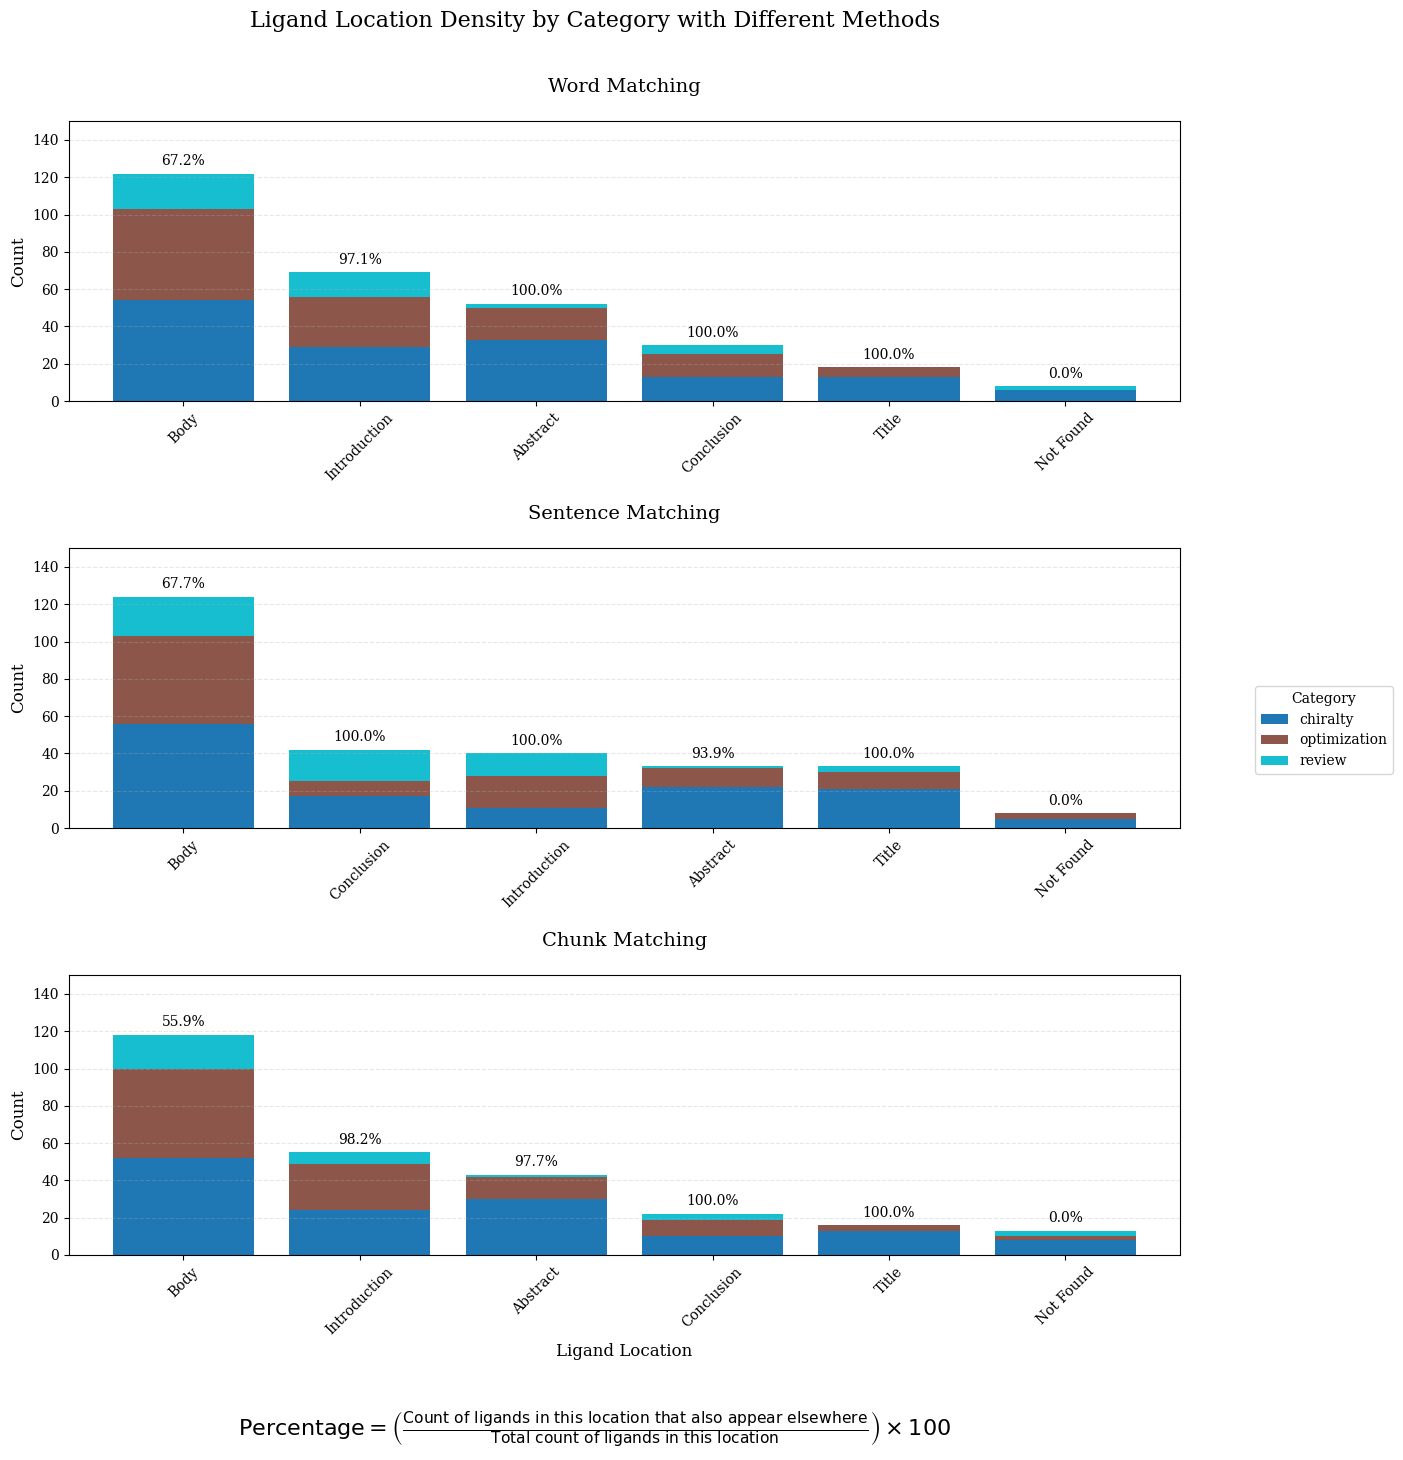

In [10]:
import matplotlib.pyplot as plt

# Set the font globally for all plots
plt.rcParams['font.family'] = 'serif'  # You can change 'serif' to any font family you prefer
plt.rcParams['font.sans-serif'] = 'Arial'  # Example for a specific sans-serif font (if desired)

# Create 3 subplots (3 rows, 1 column)
fig, axes = plt.subplots(3, 1, figsize=(12, 15))

# Define the columns to plot
Ligand_location_columns = ['Ligand_Location1', 'Ligand_Location2', 'Ligand_Location3']
Methods_list = ['Word Matching', 'Sentence Matching', 'Chunk Matching']

for i, column in enumerate(Ligand_location_columns):
    # Expand the column into separate rows
    expanded_df = clean_df.assign(Ligand_Location=clean_df[column].str.split(', ')).explode('Ligand_Location')

    # Count occurrences of each Ligand_Location and Category
    location_counts = expanded_df.groupby(['Ligand_Location', 'Category']).size().reset_index(name='Count')

    # Pivot the data for a stacked bar chart
    pivot_df = location_counts.pivot(index='Ligand_Location', columns='Category', values='Count').fillna(0)

    pivot_df = pivot_df.loc[pivot_df.sum(axis=1).sort_values(ascending=False).index]

    # Compute the total count of ligands per location
    total_counts = expanded_df.groupby('Ligand_Location')['Ligand_Location'].count()

    # Compute how many ligands in each location also appear elsewhere
    ligands_in_multiple_locations = expanded_df.groupby('Ligand_Location')['Ligand_Location'].apply(
        lambda x: (expanded_df['Ligand_Location'].isin(x) & (expanded_df[column] != x.name)).sum()
    )

    # Calculate percentages
    percentages = (ligands_in_multiple_locations.reindex(total_counts.index, fill_value=0) / total_counts * 100).fillna(0)

    # Plot stacked bar chart
    ax = pivot_df.plot(kind='bar', stacked=True, ax=axes[i], cmap='tab10', width=0.8, legend=False)

    # Customize each subplot
    axes[i].set_title(f'\n{Methods_list[i]}\n', fontsize=14)
    axes[i].set_ylabel('Count', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_ylim(0, 150)
    axes[i].set_xlabel('' if i < 2 else 'Ligand Location', fontsize=12)
    axes[i].grid(True, axis='y', linestyle='--', alpha=0.3)

    # Set y-limit with extra space for labels
    max_height = 150
    
    # Add percentage labels on top of each bar
    for loc in pivot_df.index:
        total_height = pivot_df.loc[loc].sum()
        if total_height > 0:
            axes[i].text(
                pivot_df.index.get_loc(loc),
                total_height + (max_height * 0.02),
                f'{percentages[loc]:.1f}%',
                ha='center',
                va='bottom',
                fontsize=10
            )

# Create shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Category', bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)

# Main title
fig.suptitle('Ligand Location Density by Category with Different Methods\n', fontsize=16)

# Show the plot
plt.tight_layout()

# Adjust the spacing at the bottom to avoid overlap
plt.subplots_adjust(bottom=0.15)

# Add LaTeX-formatted text at the bottom of the figure
latex_text = r'$\text{Percentage} = \left(\frac{\text{Count of ligands in this location that also appear elsewhere}}{\text{Total count of ligands in this location}}\right) \times 100$'
plt.figtext(0.5, 0.02, latex_text, ha='center', va='bottom', fontsize=16)


plt.show()


### Extraction using only Body or main content

In [11]:
# Merge dataframes based on DOI
merged_df = pd.merge(dataset, articles, left_on='reported', right_on='DOI', how='left')

# Function to check if ligand name has at least 50% similarity in the text
def find_ligand_location(ligand, text, threshold=0.4):
    if isinstance(text, str):
        # Lowercase for case-insensitive comparison
        ligand_lower = ligand.lower()
        text_lower = text.lower()
        
        # Tokenize the text into words for similarity matching
        words = text_lower.split()
        matches = [difflib.SequenceMatcher(None, ligand_lower, word).ratio() for word in words]
        
        # Check if any word matches above the threshold
        if any(match >= threshold for match in matches):
            return True
    return False

# Iterate over each ligand and check all sections
def locate_ligand(row):
    ligand = row['ligand']
    # sections = ['Body']
    sections = ['Main Content']
    found_sections = []

    # Check each section for the ligand
    for section in sections:
        if find_ligand_location(ligand, row[section]):
            found_sections.append(section)
    
    # Return the found sections or 'Not Found'
    return ', '.join(found_sections) if found_sections else 'Not Found'

# Apply the function to the merged dataframe
merged_df['Ligand_Location1'] = merged_df.apply(locate_ligand, axis=1)

# Function to split text into sentences
def split_into_sentences(text):
    if isinstance(text, str):
        # Split by sentence-ending punctuation (.!?)
        return re.split(r'[.!?]\s+', text)
    return []

# Function to check if ligand has at least 50% similarity in any sentence
def find_ligand_location(ligand, text, threshold=0.25):
    if isinstance(text, str):
        ligand_lower = ligand.lower()
        sentences = split_into_sentences(text.lower())
        
        # Compute similarity for each sentence
        for sentence in sentences:
            similarity = difflib.SequenceMatcher(None, ligand_lower, sentence).ratio()
            if similarity >= threshold:
                return True
    return False

# Iterate over each ligand and check all sections
def locate_ligand(row):
    ligand = row['ligand']
    # sections = ['Body']
    sections = ['Main Content']
    found_sections = []

    # Check each section for the ligand
    for section in sections:
        if find_ligand_location(ligand, row[section]):
            found_sections.append(section)
    
    # Return the found sections or 'Not Found'
    return ', '.join(found_sections) if found_sections else 'Not Found'

# Apply the function to the merged dataframe
merged_df['Ligand_Location2'] = merged_df.apply(locate_ligand, axis=1)


# Function to split text every two spaces (skipping one space in between)
def split_into_chunks(text):
    if isinstance(text, str):
        # Use regex to match two words separated by exactly one space
        return re.findall(r'\S+ \S+ \S+', text)
    return []


# Function to check if ligand has at least 50% similarity in any chunk
def find_ligand_location(ligand, text, threshold=0.45):
    if isinstance(text, str):
        ligand_lower = ligand.lower()
        chunks = split_into_chunks(text.lower())
        
        # Compute similarity for each chunk
        for chunk in chunks:
            similarity = difflib.SequenceMatcher(None, ligand_lower, chunk).ratio()
            if similarity >= threshold:
                return True
    return False

# Iterate over each ligand and check all sections
def locate_ligand(row):
    ligand = row['ligand']
    # sections = ['Body']
    sections = ['Main Content']
    found_sections = []

    # Check each section for the ligand
    for section in sections:
        if find_ligand_location(ligand, row[section]):
            found_sections.append(section)
    
    # Return the found sections or 'Not Found'
    return ', '.join(found_sections) if found_sections else 'Not Found'

# Apply the function to the merged dataframe
merged_df['Ligand_Location3'] = merged_df.apply(locate_ligand, axis=1)

clean_df = merged_df[['ligand', 'Filename','Category' , 'Ligand_Location1', 'Ligand_Location2', 'Ligand_Location3']]

section_under_study = 'Main Content' #! If you change this, you need to change the code above as well
not_found_percentage = (clean_df[['Ligand_Location1', 'Ligand_Location2', 'Ligand_Location3']] != 'Not Found').mean() * 100
print(f"The pecentage that could be found using {section_under_study}\n", not_found_percentage)

The pecentage that could be found using Main Content
 Ligand_Location1    94.074074
Ligand_Location2    91.851852
Ligand_Location3    89.629630
dtype: float64


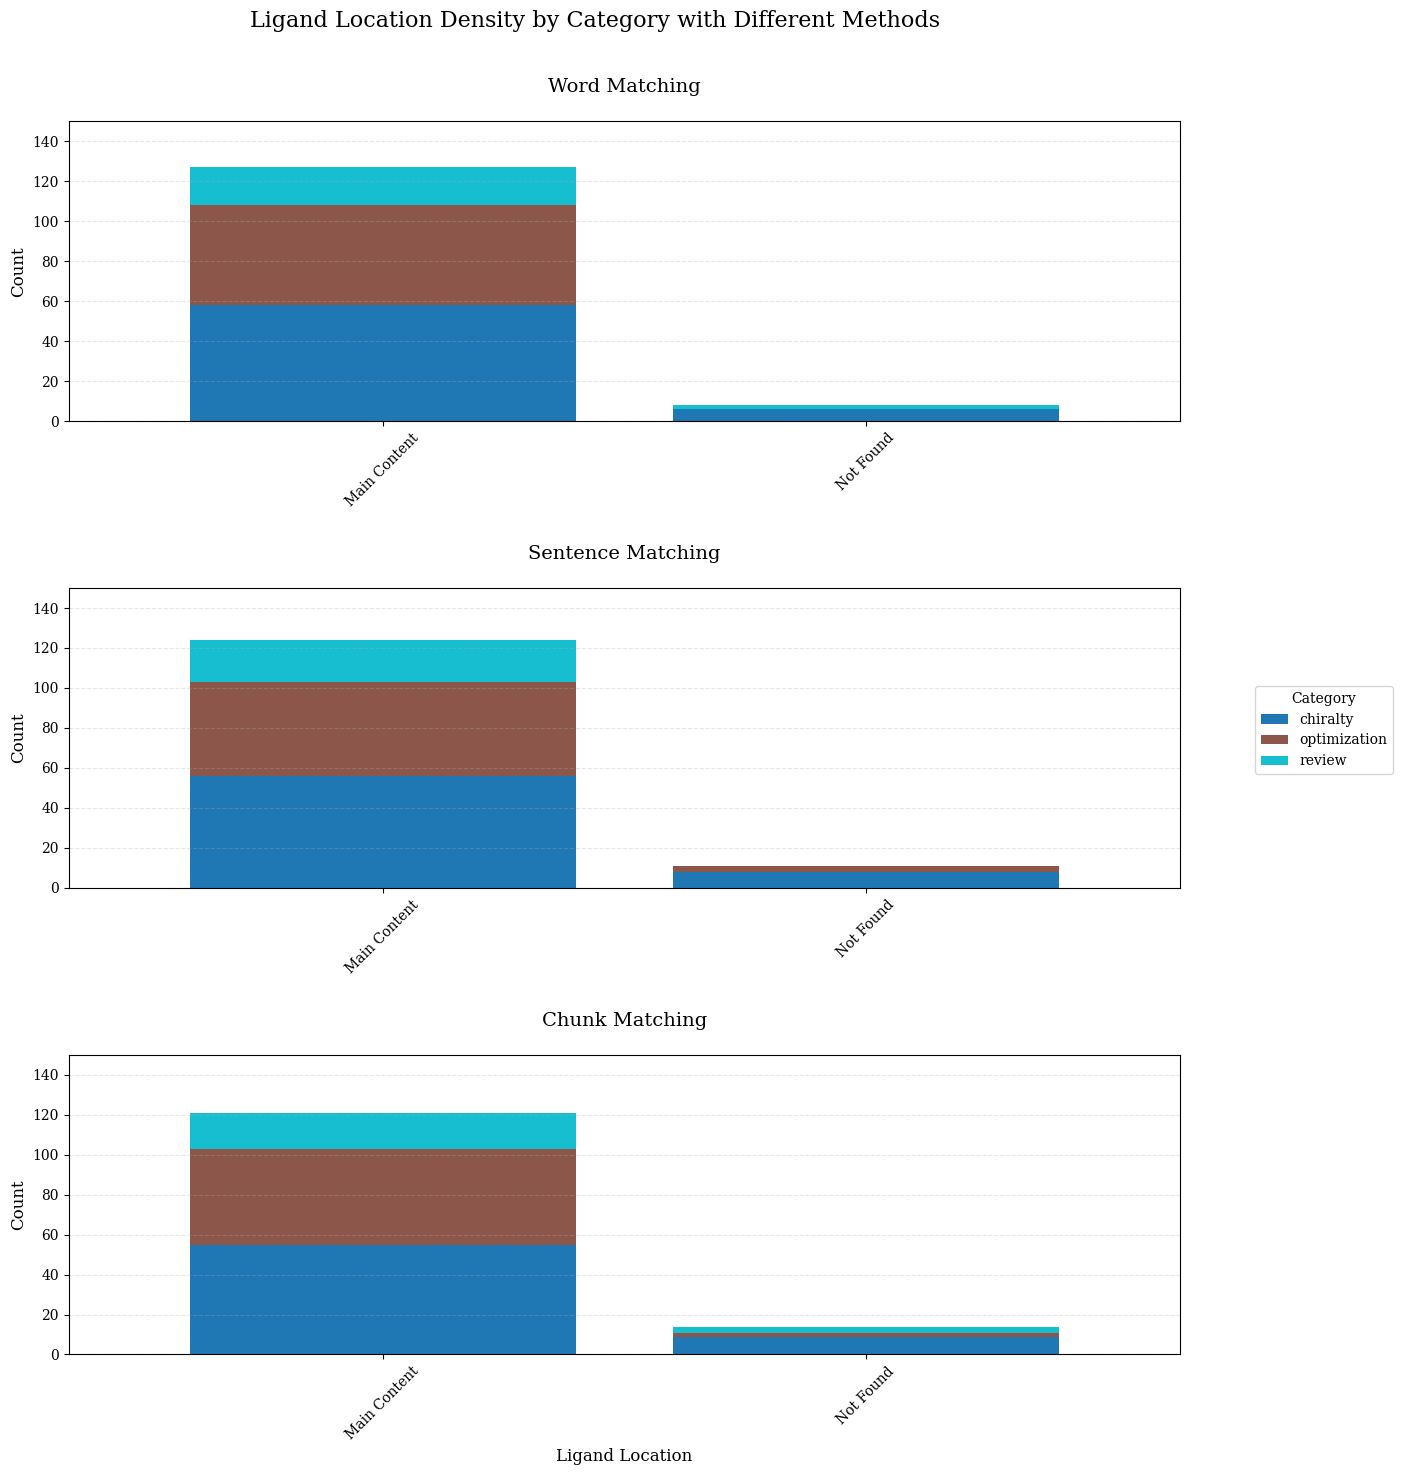

In [12]:
import matplotlib.pyplot as plt

# Set the font globally for all plots
# plt.style.use("science")
plt.rcParams['font.family'] = 'serif'  # You can change 'serif' to any font family you prefer
plt.rcParams['font.sans-serif'] = 'Arial'  # Example for a specific sans-serif font (if desired)


# Create 3 subplots (3 rows, 1 column)
fig, axes = plt.subplots(3, 1)

# Define the columns to plot
Ligand_location_columns = ['Ligand_Location1', 'Ligand_Location2', 'Ligand_Location3']
Methods_list = ['Word Matching', 'Sentence Matching', 'Chunk Matching']

# Loop over the columns and create a plot for each one
for i, column in enumerate(Ligand_location_columns):
    # Expand the column into separate rows
    expanded_df = clean_df.assign(Ligand_Location=clean_df[column].str.split(', ')).explode('Ligand_Location')

    # Count occurrences of each Ligand_Location and Category
    location_counts = expanded_df.groupby(['Ligand_Location', 'Category']).size().reset_index(name='Count')

    # Pivot the data to prepare for a stacked bar chart
    pivot_df = location_counts.pivot_table(index='Ligand_Location', columns='Category', values='Count', fill_value=0)

    # Sort by total counts for better visualization
    pivot_df = pivot_df.loc[pivot_df.sum(axis=1).sort_values(ascending=False).index]

    # Plot the stacked bar chart on the corresponding axis
    ax = pivot_df.plot(kind='bar', stacked=True, ax=axes[i], figsize=(12, 15), cmap='tab10', width=0.8, legend=False)

    # Customize the plot for each axis
    axes[i].set_title(f'\n{Methods_list[i]}\n', fontsize=14)
    axes[i].set_ylabel('Count', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, axis='y', linestyle='--', alpha=0.3)
    
    # Set the same y-axis limit across all subplots
    axes[i].set_ylim(0, 150)
    axes[i].set_xlabel('', fontsize=12)
    # Add x-axis label only to the last subplot (bottom one)
    if i == 2:
        axes[i].set_xlabel('Ligand Location', fontsize=12)

# Create one shared legend for all subplots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Category', bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)

# Add a main title for the entire figure
fig.suptitle('Ligand Location Density by Category with Different Methods\n', fontsize=16)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


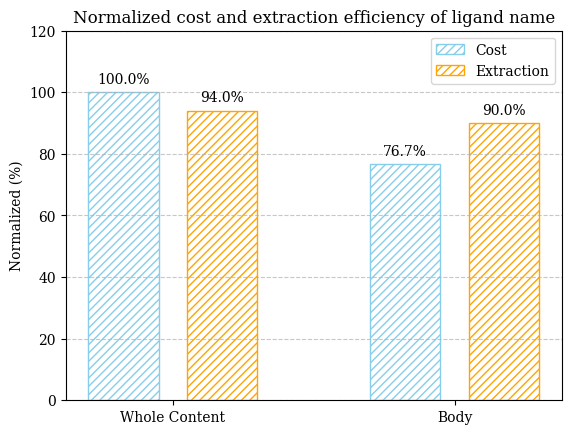

Ratio of Body to Main Content Tokens: 0.7671125098347757


In [13]:
import tiktoken
import numpy as np
import matplotlib.pyplot as plt

encoding = tiktoken.encoding_for_model("gpt-4o")
Main_content_tokens = []
Body_tokens = []

for i in range(len(articles['Main Content'])):
    Main_content_tokens.append(len(encoding.encode(articles['Main Content'][0])))
    Body_tokens.append(len(encoding.encode(articles['Body'][0])))

Mean_main_content_tokens = sum(Main_content_tokens) / len(Main_content_tokens)
Mean_body_tokens = sum(Body_tokens) / len(Body_tokens)

ratio = Mean_body_tokens / Mean_main_content_tokens

Main_content_accuracy = 94 #! HARD CODED from the previous analysis above
Body_accuracy = 90 #! HARD CODED from the previous analysis above

labels = ['Whole Content', 'Body']
x = np.arange(len(labels))
values1 = [100, Mean_body_tokens/Mean_main_content_tokens*100]
values2 = [Main_content_accuracy, Body_accuracy]

width = 0.25

bars1 = plt.bar(x - width/2 - 0.05, values1, width, label='Cost', hatch='////', color='none', edgecolor='skyblue')
bars2 = plt.bar(x + width/2 + 0.05, values2, width, label='Extraction', hatch='////', color='none', edgecolor='orange')

# Adding text on top of each bar
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 2, f'{yval:.1f}%', ha='center', va='bottom')

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 2, f'{yval:.1f}%', ha='center', va='bottom')

plt.ylabel('Normalized (%)')
plt.title('Normalized cost and extraction efficiency of ligand name')
plt.xticks(x, labels)
plt.legend()
plt.ylim(0, 120)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()
print('Ratio of Body to Main Content Tokens:', ratio)
